# CNN-Based Video Tampering Detection Using Synthetic Texture Analysis
### B.Tech Final Year Capstone Project — CSE461
**Lovely Professional University | School of Computer Science and Engineering**

---

**Team Members:**
| Name | Roll Number |
|------|-------------|
| Archit Gupta | 12213254 |
| Harsh Dubey | 12208394 |
| Ansh Khurana | 12217489 |

**Supervisor:** Mr. Sparsh Raj  
**Session:** Jan 2026 – May 2026

---

## Project Overview

This notebook implements a deep learning pipeline to detect video tampering using **CNN-based Synthetic Texture Analysis**. The system:

1. Loads pre-extracted frames from authentic and manipulated security videos
2. Augments data to improve generalization
3. Extracts **Local Binary Pattern (LBP)** texture features as a secondary channel
4. Trains a **dual-input CNN** that fuses RGB frame features with texture maps
5. Evaluates performance using standard classification metrics
6. Provides a frame-level decision mechanism for video-level authenticity prediction

---

## Section 1: Environment Setup & Imports

All required libraries are imported in a single cell for clarity and reproducibility. We fix a global random seed to ensure consistent results across runs.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.utils import class_weight

# Scikit-image for texture analysis
from skimage.feature import local_binary_pattern

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization, Concatenate, Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version : {tf.__version__}")
print(f"GPU available      : {bool(tf.config.list_physical_devices('GPU'))}")
print(f"Working directory  : {os.getcwd()}")

TensorFlow version : 2.20.0
GPU available      : False
Working directory  : C:\Users\gupta\Capstone Project


---
## Section 2: Configuration & Hyperparameters

All key configuration values are centralised here so they can be modified in a single place without hunting through the notebook.

In [2]:
# ── Data ────────────────────────────────────────────────────────────────────
DATA_DIR            = "D:/Capstone Project"          # Root project directory
REAL_FRAMES_DIR     = os.path.join(DATA_DIR, "frames", "Real")
FAKE_FRAMES_DIR     = os.path.join(DATA_DIR, "frames", "Fake")

# ── Preprocessing ───────────────────────────────────────────────────────────
IMG_SIZE            = 128    # Height & width to resize each frame
MAX_FRAMES_PER_VIDEO = 20    # Cap frames sampled per video folder

# ── LBP Texture ─────────────────────────────────────────────────────────────
LBP_RADIUS          = 1      # Neighbourhood radius for LBP
LBP_N_POINTS        = 8      # Number of circularly symmetric neighbour points

# ── Training ────────────────────────────────────────────────────────────────
BATCH_SIZE          = 32
EPOCHS              = 40
LEARNING_RATE       = 1e-4
VALIDATION_SPLIT    = 0.15   # 15 % of training data → validation set
TEST_SPLIT          = 0.20   # 20 % of full dataset → held-out test set

# ── Paths ────────────────────────────────────────────────────────────────────
MODEL_SAVE_PATH     = os.path.join(DATA_DIR, "best_model.keras")

print("Configuration loaded successfully.")

Configuration loaded successfully.


---
## Section 3: Dataset Loading & Preprocessing

Frames were previously extracted from raw videos and organised into two directories:
- `frames/Real/` — one sub-folder per authentic video, each containing frame images.
- `frames/Fake/` — one sub-folder per manipulated video.

Each frame is:
1. Read with OpenCV (BGR → RGB conversion)
2. Resized to `IMG_SIZE × IMG_SIZE`
3. Normalised to `[0, 1]` by dividing by 255

> **Important:** Normalisation is performed **once** here. It must **not** be repeated in subsequent cells.

In [3]:
def load_frames(base_path: str, label: int) -> list:
    """
    Recursively loads and preprocesses frames from a directory of video sub-folders.

    Parameters
    ----------
    base_path : str  – Path to the class directory (e.g. frames/Real)
    label     : int  – Class label: 0 = Real, 1 = Fake

    Returns
    -------
    List of (normalised_image_array [H,W,3], label) tuples.
    """
    data = []
    video_folders = sorted(os.listdir(base_path))

    for video in tqdm(video_folders, desc=f"Loading {'Real' if label==0 else 'Fake'}"):
        video_path = os.path.join(base_path, video)

        if not os.path.isdir(video_path):
            continue

        frames = sorted(os.listdir(video_path))[:MAX_FRAMES_PER_VIDEO]

        for frame_name in frames:
            frame_path = os.path.join(video_path, frame_name)
            img = cv2.imread(frame_path)

            if img is None:
                continue

            # Convert BGR → RGB and resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # Normalise to [0, 1]  ← done ONCE here, never repeated
            img = img.astype(np.float32) / 255.0

            data.append((img, label))

    return data


# Load both classes
real_data = load_frames(REAL_FRAMES_DIR, label=0)
fake_data = load_frames(FAKE_FRAMES_DIR, label=1)

print(f"\nReal frames loaded : {len(real_data)}")
print(f"Fake frames loaded : {len(fake_data)}")

# Combine, shuffle, and unpack
dataset = real_data + fake_data
np.random.shuffle(dataset)

X = np.array([item[0] for item in dataset], dtype=np.float32)
y = np.array([item[1] for item in dataset], dtype=np.int32)

print(f"\nCombined dataset   : X={X.shape}, y={y.shape}")
print(f"Class distribution : Real={np.sum(y==0)}, Fake={np.sum(y==1)}")

Loading Fake: 100%|██████████████████████████████████████████████████████████████████| 201/201 [01:37<00:00,  2.06it/s]



Real frames loaded : 4000
Fake frames loaded : 3975

Combined dataset   : X=(7975, 128, 128, 3), y=(7975,)
Class distribution : Real=4000, Fake=3975


---
## Section 4: Exploratory Data Analysis (EDA)

Before training, we visualise sample frames from each class and inspect the class balance to inform our training strategy.

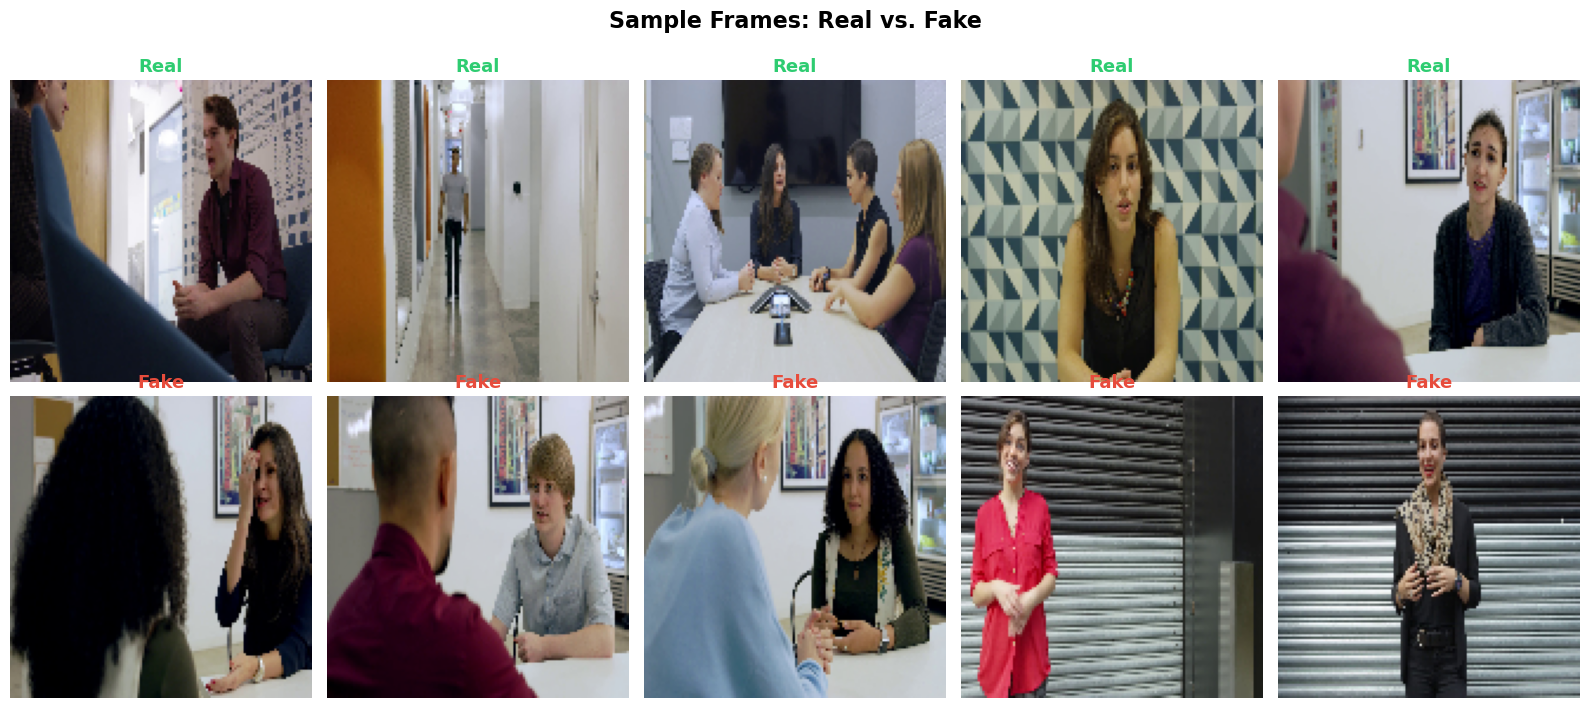

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
class_labels = {0: "Real", 1: "Fake"}
colours      = {0: "#2ecc71", 1: "#e74c3c"}

for row, cls in enumerate([0, 1]):
    indices = np.where(y == cls)[0][:5]
    for col, idx in enumerate(indices):
        axes[row, col].imshow(X[idx])
        axes[row, col].set_title(class_labels[cls], color=colours[cls],
                                 fontsize=13, fontweight='bold')
        axes[row, col].axis('off')

plt.suptitle("Sample Frames: Real vs. Fake", fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

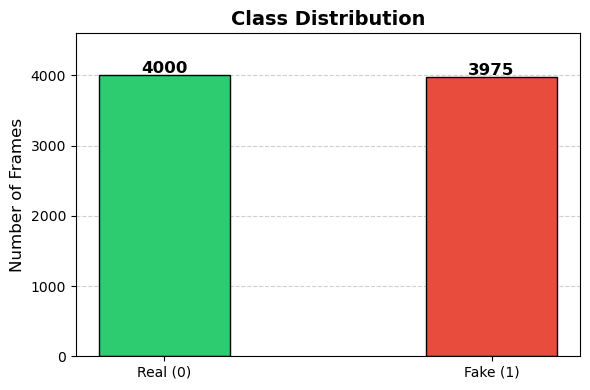

Class imbalance ratio: 1.01x  → Mild – will use class weighting


In [5]:
# Class distribution bar chart
counts = [np.sum(y == 0), np.sum(y == 1)]
labels = ["Real (0)", "Fake (1)"]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, counts, color=["#2ecc71", "#e74c3c"], width=0.4, edgecolor='black')

for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 30,
            str(count), ha='center', fontsize=12, fontweight='bold')

ax.set_title("Class Distribution", fontsize=14, fontweight='bold')
ax.set_ylabel("Number of Frames", fontsize=12)
ax.set_ylim(0, max(counts) * 1.15)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

imbalance_ratio = max(counts) / min(counts)
print(f"Class imbalance ratio: {imbalance_ratio:.2f}x  "
      f"→ {'Mild – will use class weighting' if imbalance_ratio < 2 else 'Significant – class weighting is critical'}")

---
## Section 5: LBP Texture Feature Extraction

**Local Binary Pattern (LBP)** is a classical texture descriptor that captures micro-texture patterns by comparing each pixel to its neighbours. Synthetic (AI-generated or spliced) content introduces subtle texture discontinuities that differ from natural camera noise, making LBP an effective complementary feature for tampering detection.

Each LBP map is a single-channel image of the same spatial dimensions as the RGB frame, normalised to `[0, 1]`.

In [6]:
def extract_lbp_texture(img_normalised: np.ndarray) -> np.ndarray:
    """
    Compute and normalise an LBP texture map for a single RGB frame.

    Parameters
    ----------
    img_normalised : np.ndarray, shape (H, W, 3), values in [0, 1]

    Returns
    -------
    lbp_norm : np.ndarray, shape (H, W, 1), values in [0, 1]
    """
    # Convert back to uint8 for OpenCV
    img_uint8 = (img_normalised * 255).astype(np.uint8)

    # Convert RGB → Grayscale
    gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)

    # Compute LBP
    lbp = local_binary_pattern(gray, P=LBP_N_POINTS, R=LBP_RADIUS, method='uniform')

    # Normalise LBP map to [0, 1]
    lbp_max = lbp.max()
    lbp_norm = (lbp / lbp_max) if lbp_max > 0 else lbp

    return lbp_norm.astype(np.float32)[..., np.newaxis]   # shape (H, W, 1)


# Extract texture for the full dataset
print("Extracting LBP texture maps (this may take a minute)...")
X_texture = np.array(
    [extract_lbp_texture(img) for img in tqdm(X, desc="LBP")],
    dtype=np.float32
)

print(f"\nRGB array shape     : {X.shape}")
print(f"Texture array shape : {X_texture.shape}")

Extracting LBP texture maps (this may take a minute)...


LBP: 100%|████████████████████████████████████████████████████████████████████████| 7975/7975 [00:19<00:00, 415.78it/s]



RGB array shape     : (7975, 128, 128, 3)
Texture array shape : (7975, 128, 128, 1)


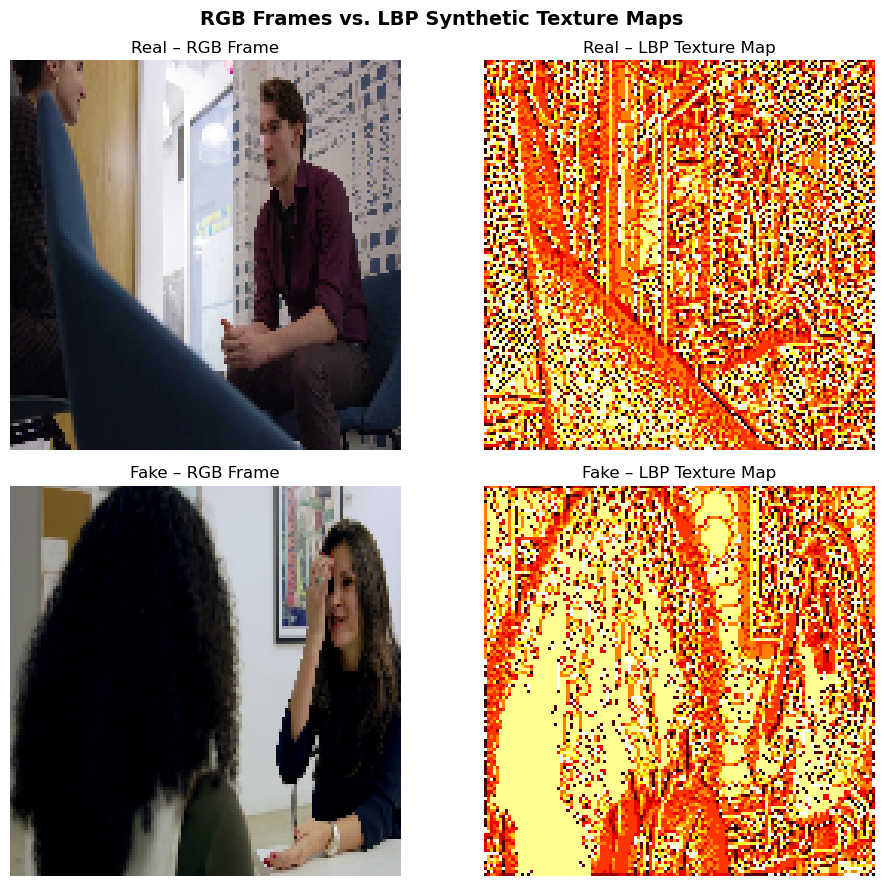

In [7]:
# Visualise LBP maps for one Real and one Fake frame
real_idx = np.where(y == 0)[0][0]
fake_idx = np.where(y == 1)[0][0]

fig, axes = plt.subplots(2, 2, figsize=(10, 9))

axes[0, 0].imshow(X[real_idx]);              axes[0, 0].set_title("Real – RGB Frame", fontsize=12)
axes[0, 1].imshow(X_texture[real_idx, :, :, 0], cmap='hot');
axes[0, 1].set_title("Real – LBP Texture Map", fontsize=12)
axes[1, 0].imshow(X[fake_idx]);              axes[1, 0].set_title("Fake – RGB Frame", fontsize=12)
axes[1, 1].imshow(X_texture[fake_idx, :, :, 0], cmap='hot');
axes[1, 1].set_title("Fake – LBP Texture Map", fontsize=12)

for ax in axes.flat:
    ax.axis('off')

plt.suptitle("RGB Frames vs. LBP Synthetic Texture Maps", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Section 6: Train / Validation / Test Split

We partition the data into three non-overlapping sets:
- **Train (64%)** – used to update model weights
- **Validation (16%)** – used to monitor generalisation and drive early stopping
- **Test (20%)** – held out, never seen during training or tuning

`stratify=y` ensures each split preserves the original class ratio.

In [8]:
# Step 1: carve out the held-out test set (20 %)
X_trainval, X_test, X_tex_trainval, X_tex_test, y_trainval, y_test = train_test_split(
    X, X_texture, y,
    test_size=TEST_SPLIT,
    stratify=y,
    random_state=SEED
)

# Step 2: split the remaining data into train / validation (~80 % / 20 % of trainval)
X_train, X_val, X_tex_train, X_tex_val, y_train, y_val = train_test_split(
    X_trainval, X_tex_trainval, y_trainval,
    test_size=VALIDATION_SPLIT / (1 - TEST_SPLIT),
    stratify=y_trainval,
    random_state=SEED
)

print(f"Train      : {X_train.shape[0]:>5} frames  |  Real: {np.sum(y_train==0)}, Fake: {np.sum(y_train==1)}")
print(f"Validation : {X_val.shape[0]:>5} frames  |  Real: {np.sum(y_val==0)},  Fake: {np.sum(y_val==1)}")
print(f"Test       : {X_test.shape[0]:>5} frames  |  Real: {np.sum(y_test==0)}, Fake: {np.sum(y_test==1)}")

Train      :  5183 frames  |  Real: 2600, Fake: 2583
Validation :  1197 frames  |  Real: 600,  Fake: 597
Test       :  1595 frames  |  Real: 800, Fake: 795


---
## Section 7: Data Augmentation

Augmentation is applied **only to the training set** using Keras `ImageDataGenerator`. It artificially expands the dataset by applying stochastic transformations, improving the model's robustness to real-world variations in lighting, orientation, and zoom.

We create **two synchronised generators** (one for RGB, one for texture) using the same random seed so that transformations are aligned across both inputs.

In [9]:
AUG_SEED = 2024

augmentation_args = dict(
    rotation_range      = 15,
    width_shift_range   = 0.10,
    height_shift_range  = 0.10,
    zoom_range          = 0.15,
    horizontal_flip     = True,
    shear_range         = 0.08,
    fill_mode           = 'nearest'
)

# Generators for RGB and Texture channels — identical random transforms
rgb_datagen = ImageDataGenerator(**augmentation_args)
tex_datagen = ImageDataGenerator(**augmentation_args)

def dual_generator(X_rgb, X_tex, labels, class_wts, batch_size=BATCH_SIZE, seed=AUG_SEED):
    """
    Yields synchronised batches of ([RGB, Texture], label, sample_weight).
    Sample weights replace class_weight since Keras generators don't support
    class_weight directly. Each sample is weighted by its class's inverse frequency.
    Both augmentation generators receive the same seed per batch so transforms
    are spatially aligned across the two input branches.
    """
    gen_rgb = rgb_datagen.flow(X_rgb, labels, batch_size=batch_size, seed=seed)
    gen_tex = tex_datagen.flow(X_tex, labels, batch_size=batch_size, seed=seed)

    while True:
        X_rgb_batch, y_batch = next(gen_rgb)
        X_tex_batch, _       = next(gen_tex)
        # Map each label to its class weight → per-sample weight vector
        sw = np.array([class_wts[int(lbl)] for lbl in y_batch], dtype=np.float32)
        yield (X_rgb_batch, X_tex_batch), y_batch, sw


# NOTE: class_weights will be computed in the next cell and passed here.
# We define the generator factory now; it is instantiated after class_weights are ready.
print("Augmentation configuration ready.")
print(f"Steps per epoch : {len(X_train) // BATCH_SIZE}")


Augmentation configuration ready.
Steps per epoch : 161


---
## Section 8: Model Architecture — Dual-Input Fusion CNN

We design a **dual-input CNN** with two parallel feature extraction branches:

| Branch | Input | Purpose |
|--------|-------|--------|
| **RGB Branch** | (128, 128, 3) | Learns appearance-level tampering artifacts |
| **Texture Branch** | (128, 128, 1) | Learns synthetic micro-texture anomalies via LBP |

Features from both branches are concatenated and passed through fully-connected layers for binary classification. This fusion approach leverages complementary information and is the core technical novelty of the project.

**Design choices:**
- `BatchNormalization` after each Conv block stabilises training and speeds convergence
- `Dropout(0.4)` on dense layers reduces overfitting
- `ReduceLROnPlateau` callback automatically decays the learning rate when validation loss plateaus
- `EarlyStopping` with `restore_best_weights=True` prevents overfitting

In [10]:
def conv_block(x, filters, kernel=3):
    """A single Conv → BN → ReLU → MaxPool block."""
    x = Conv2D(filters, (kernel, kernel), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    return x


def build_dual_input_cnn(img_size: int = IMG_SIZE, lr: float = LEARNING_RATE) -> Model:
    """
    Builds a dual-input CNN that fuses RGB and LBP texture features.

    Architecture
    ────────────
    RGB Branch   (3-ch)  → [32 → 64 → 128] Conv blocks → GAP
    Texture Branch (1-ch)→ [16 → 32 → 64 ] Conv blocks → GAP
    Concatenate → Dense(256, relu) → Dropout → Dense(64, relu) → Dense(1, sigmoid)
    """
    # ── RGB Branch ───────────────────────────────────────────────────────────
    rgb_input = Input(shape=(img_size, img_size, 3), name="rgb_input")
    x = conv_block(rgb_input, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = GlobalAveragePooling2D(name="rgb_gap")(x)

    # ── Texture Branch ───────────────────────────────────────────────────────
    tex_input = Input(shape=(img_size, img_size, 1), name="texture_input")
    t = conv_block(tex_input, 16)
    t = conv_block(t, 32)
    t = conv_block(t, 64)
    t = GlobalAveragePooling2D(name="tex_gap")(t)

    # ── Fusion ───────────────────────────────────────────────────────────────
    fused = Concatenate(name="fusion")([x, t])
    fused = Dense(256, activation='relu', name="fc1")(fused)
    fused = BatchNormalization()(fused)
    fused = Dropout(0.4)(fused)
    fused = Dense(64, activation='relu', name="fc2")(fused)
    fused = Dropout(0.3)(fused)
    output = Dense(1, activation='sigmoid', name="output")(fused)

    model = Model(inputs=[rgb_input, tex_input], outputs=output,
                  name="DualInput_TextureCNN")

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model


model = build_dual_input_cnn()
model.summary()

Model: "DualInput_TextureCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ rgb_input (InputLayer)        │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ texture_input (InputLayer)    │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 32)      │             896 │ rgb_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 16)      │             160 │ texture_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 128, 128, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 128, 128, 16)      │              64 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 32)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 64, 64, 16)        │               0 │ batch_normalization_3[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 32)        │           4,640 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 64, 64, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 64, 64, 32)        │             128 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 64)        │               0 │ batch_normalization_1[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 32, 32, 32)        │               0 │ batch_normalization_4[0][… │
│ (MaxPooling2D)                │                           │               

 Total params: 184,833 (722.00 KB)

 Trainable params: 183,649 (717.38 KB)

 Non-trainable params: 1,184 (4.62 KB)

---
## Section 9: Class Weighting

If the dataset is imbalanced (more Real frames than Fake or vice versa), the model might be biased towards the majority class. We compute **inverse-frequency class weights** using `sklearn` to penalise misclassification of the minority class more heavily during training.

In [11]:
from sklearn.utils import class_weight as cw_module

weights_array = cw_module.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {int(cls): float(w) for cls, w in zip(np.unique(y_train), weights_array)}

print("Computed class weights:")
for cls, w in class_weights.items():
    print(f"  Class {cls} ({'Real' if cls==0 else 'Fake'}): weight = {w:.4f}")

# Instantiate the dual generator now that class_weights are available
steps_per_epoch = len(X_train) // BATCH_SIZE
train_gen = dual_generator(X_train, X_tex_train, y_train, class_weights)

print(f"\nTrain generator ready — {steps_per_epoch} steps/epoch")


Computed class weights:
  Class 0 (Real): weight = 0.9967
  Class 1 (Fake): weight = 1.0033

Train generator ready — 161 steps/epoch


---
## Section 10: Model Training

Three callbacks are used:

| Callback | Purpose |
|----------|---------|
| `EarlyStopping` | Halts training when val loss stops improving; restores best weights |
| `ModelCheckpoint` | Saves the best model to disk based on val accuracy |
| `ReduceLROnPlateau` | Halves the learning rate if val loss does not improve for 4 epochs |

In [12]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1
    )
]

# Validation data: dual-input format (no augmentation on val/test sets)
val_data = ([X_val, X_tex_val], y_val)

print("Starting model training...")
print(f"Train samples     : {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print("-" * 50)

# Note: class_weight is baked into per-sample weights inside dual_generator.
# Keras does not support class_weight with Python generators — we pass sample
# weights as the third element of each yielded tuple instead.
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete.")


Starting model training...
Train samples     : 5183
Validation samples: 1197
--------------------------------------------------
Epoch 1/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5057 - auc: 0.5005 - loss: 0.8654
Epoch 1: val_accuracy improved from None to 0.49875, saving model to D:/Capstone Project\best_model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.5225 - auc: 0.5221 - loss: 0.8324 - val_accuracy: 0.4987 - val_auc: 0.5235 - val_loss: 0.7232 - learning_rate: 1.0000e-04
Epoch 2/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.5492 - auc: 0.5663 - loss: 0.7700
Epoch 2: val_accuracy improved from 0.49875 to 0.50794, saving model to D:/Capstone Project\best_model.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 141s 875ms/step - accuracy: 0.5548 - auc: 0.5695 - loss: 0.7686 - val_accuracy: 0.5079 - val_auc: 0.5547 - val_loss: 0.7079 - learning_rate: 1.0000e-04
Epoch 3/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.5679 - auc: 0.5948 - loss: 0.

---
## Section 11: Training Curves

Plotting accuracy and loss curves for both training and validation sets allows us to visually inspect convergence and detect overfitting.

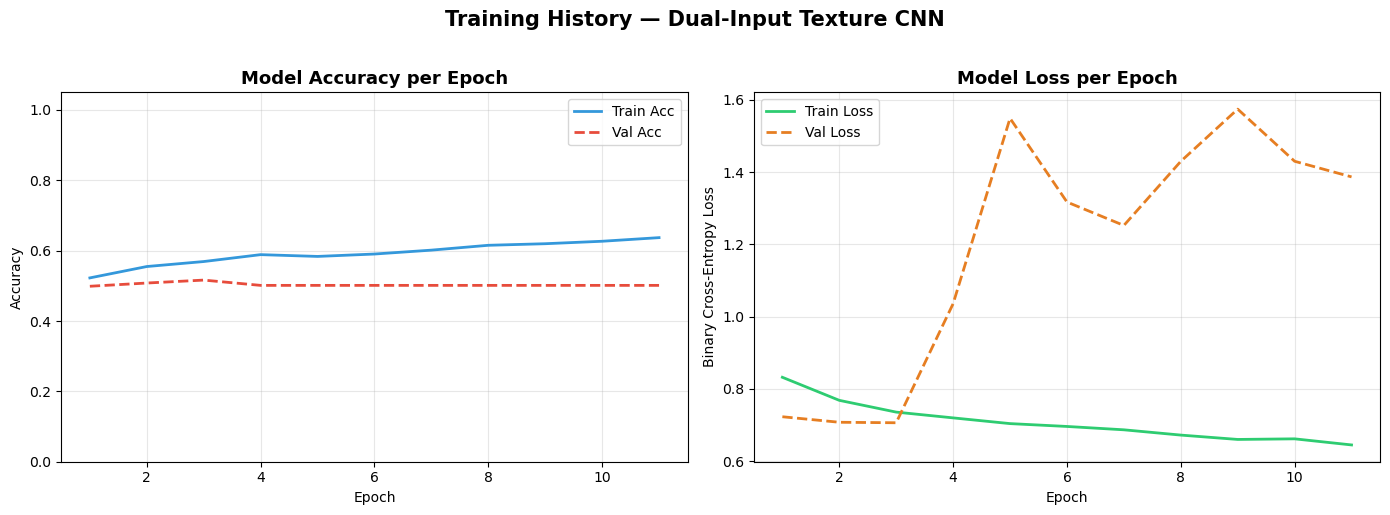

In [13]:
def plot_training_history(hist):
    """Plot Accuracy and Loss curves side-by-side."""
    epochs_ran = range(1, len(hist.history['accuracy']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(epochs_ran, hist.history['accuracy'],    label='Train Acc',  linewidth=2, color='#3498db')
    axes[0].plot(epochs_ran, hist.history['val_accuracy'], label='Val Acc',   linewidth=2, color='#e74c3c', linestyle='--')
    axes[0].set_title('Model Accuracy per Epoch', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Epoch');  axes[0].set_ylabel('Accuracy')
    axes[0].legend();  axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1.05)

    # Loss
    axes[1].plot(epochs_ran, hist.history['loss'],     label='Train Loss', linewidth=2, color='#2ecc71')
    axes[1].plot(epochs_ran, hist.history['val_loss'], label='Val Loss',   linewidth=2, color='#e67e22', linestyle='--')
    axes[1].set_title('Model Loss per Epoch', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Epoch');  axes[1].set_ylabel('Binary Cross-Entropy Loss')
    axes[1].legend();  axes[1].grid(True, alpha=0.3)

    plt.suptitle("Training History — Dual-Input Texture CNN", fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


plot_training_history(history)

---
## Section 12: Model Evaluation on Held-Out Test Set

All evaluation is performed on the **test set**, which was never used during training or hyperparameter tuning. We report:
- **Accuracy** — overall correctness
- **Precision** — of all predicted Fakes, how many are truly Fake
- **Recall** — of all actual Fakes, how many did we catch
- **F1-Score** — harmonic mean of Precision and Recall
- **AUC-ROC** — discriminative power regardless of threshold

In [14]:
print("Evaluating on held-out test set...\n")

# Raw probability predictions
y_prob = model.predict([X_test, X_tex_test], batch_size=BATCH_SIZE, verbose=1).flatten()

# Convert to binary predictions at threshold 0.5
y_pred = (y_prob >= 0.5).astype(int)

# Metrics
test_loss, test_acc, test_auc = model.evaluate(
    [X_test, X_tex_test], y_test,
    batch_size=BATCH_SIZE, verbose=0
)

print(f"\n{'='*50}")
print(f"  Test Accuracy  : {test_acc  * 100:.2f}%")
print(f"  Test AUC-ROC   : {test_auc  * 100:.2f}%")
print(f"  Test Loss      : {test_loss:.4f}")
print(f"{'='*50}\n")

print("Classification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=['Real (0)', 'Fake (1)'],
    digits=4
))

Evaluating on held-out test set...

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step

  Test Accuracy  : 52.23%
  Test AUC-ROC   : 58.84%
  Test Loss      : 0.7086

Classification Report:
              precision    recall  f1-score   support

    Real (0)     0.5129    0.9463    0.6652       800
    Fake (1)     0.6387    0.0956    0.1663       795

    accuracy                         0.5223      1595
   macro avg     0.5758    0.5209    0.4158      1595
weighted avg     0.5756    0.5223    0.4165      1595



---
## Section 13: Confusion Matrix

The confusion matrix gives a detailed breakdown of true positives, true negatives, false positives, and false negatives.

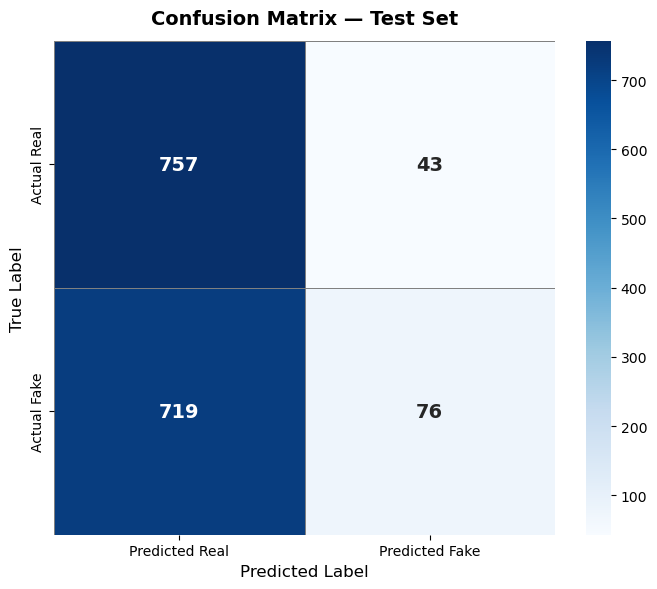

True Negatives  (Real correctly identified) : 757
False Positives (Real wrongly flagged)      : 43
False Negatives (Fake missed)               : 719
True Positives  (Fake correctly detected)   : 76


In [15]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Predicted Real', 'Predicted Fake'],
    yticklabels=['Actual Real', 'Actual Fake'],
    linewidths=0.5, linecolor='gray',
    annot_kws={'size': 14, 'weight': 'bold'}
)

ax.set_title('Confusion Matrix — Test Set', fontsize=14, fontweight='bold', pad=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives  (Real correctly identified) : {tn}")
print(f"False Positives (Real wrongly flagged)      : {fp}")
print(f"False Negatives (Fake missed)               : {fn}")
print(f"True Positives  (Fake correctly detected)   : {tp}")

---
## Section 14: ROC Curve

The **Receiver Operating Characteristic (ROC)** curve plots the True Positive Rate against the False Positive Rate across all classification thresholds. The **Area Under the Curve (AUC)** summarises the model's discriminative ability — a perfect classifier achieves AUC = 1.0.

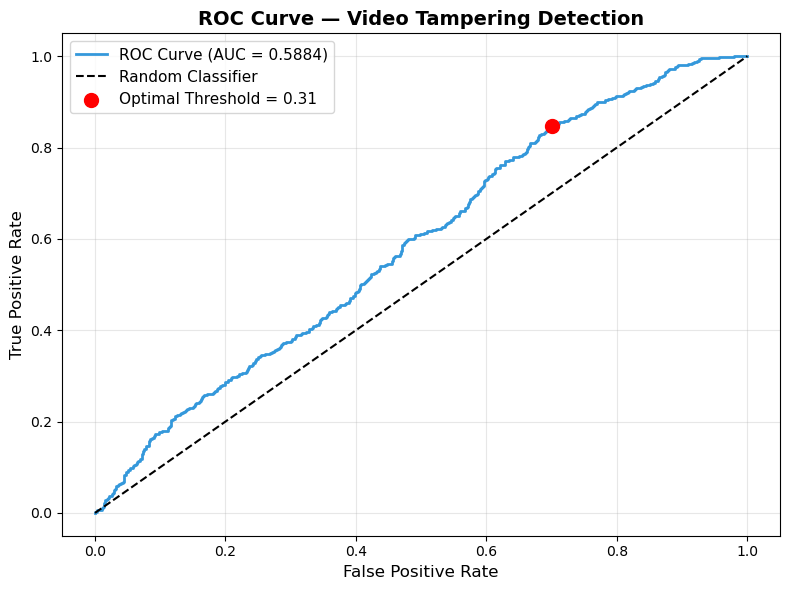

AUC-ROC Score     : 0.5884
Optimal Threshold : 0.310
  TPR at optimal  : 0.8478
  FPR at optimal  : 0.7013


In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Optimal threshold (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, lw=2, color='#3498db', label=f'ROC Curve (AUC = {auc_score:.4f})')
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier')
ax.scatter(fpr[optimal_idx], tpr[optimal_idx],
           color='red', s=100, zorder=5,
           label=f'Optimal Threshold = {optimal_threshold:.2f}')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve — Video Tampering Detection', fontsize=14, fontweight='bold')
ax.legend(fontsize=11); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC-ROC Score     : {auc_score:.4f}")
print(f"Optimal Threshold : {optimal_threshold:.3f}")
print(f"  TPR at optimal  : {tpr[optimal_idx]:.4f}")
print(f"  FPR at optimal  : {fpr[optimal_idx]:.4f}")

---
## Section 15: Video-Level Authenticity Decision

In a real deployment scenario, we receive an entire video rather than individual frames. We implement a **majority-vote aggregation** strategy:
- All frames of a video are predicted independently
- The video is classified as **Fake** if more than 40% of its frames are predicted as Fake (conservative threshold to catch partial tampering)

This mirrors real-world forensic workflows where only certain segments of a video may be manipulated.

In [17]:
def predict_video_authenticity(
    frame_dir: str,
    model,
    img_size: int = IMG_SIZE,
    fake_threshold: float = 0.40
) -> dict:
    """
    Predicts whether a video is authentic or tampered by aggregating
    frame-level predictions.

    Parameters
    ----------
    frame_dir       : Path to directory containing extracted frames of one video
    model           : Trained Keras model (dual-input)
    img_size        : Expected frame size
    fake_threshold  : Fraction of fake-predicted frames needed to flag the video

    Returns
    -------
    dict with keys: verdict, fake_fraction, n_frames, frame_scores
    """
    frame_files = sorted([
        f for f in os.listdir(frame_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

    if not frame_files:
        return {"verdict": "No frames found", "fake_fraction": None}

    rgb_batch, tex_batch = [], []

    for fname in frame_files:
        img = cv2.imread(os.path.join(frame_dir, fname))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size)).astype(np.float32) / 255.0
        tex = extract_lbp_texture(img)
        rgb_batch.append(img)
        tex_batch.append(tex)

    rgb_batch = np.array(rgb_batch, dtype=np.float32)
    tex_batch = np.array(tex_batch, dtype=np.float32)

    scores = model.predict([rgb_batch, tex_batch], verbose=0).flatten()
    fake_fraction = float(np.mean(scores >= 0.5))

    verdict = "⚠️  TAMPERED (FAKE)" if fake_fraction >= fake_threshold else "✅  AUTHENTIC (REAL)"

    return {
        "verdict"       : verdict,
        "fake_fraction" : fake_fraction,
        "n_frames"      : len(scores),
        "frame_scores"  : scores.tolist()
    }


print("Video-level prediction function ready.")
print()
print("Usage example:")
print('  result = predict_video_authenticity("frames/Real/video_001", model)')
print('  print(result["verdict"])')

Video-level prediction function ready.

Usage example:
  result = predict_video_authenticity("frames/Real/video_001", model)
  print(result["verdict"])


In [18]:
# ── Demo: Run on one Real and one Fake video folder ───────────────────────
# (Paths are set automatically using the first folders from each class)

try:
    real_folders = sorted(os.listdir(REAL_FRAMES_DIR))
    fake_folders = sorted(os.listdir(FAKE_FRAMES_DIR))

    demo_real = os.path.join(REAL_FRAMES_DIR, real_folders[0])
    demo_fake = os.path.join(FAKE_FRAMES_DIR, fake_folders[0])

    for label, path in [("REAL", demo_real), ("FAKE", demo_fake)]:
        result = predict_video_authenticity(path, model)
        print(f"Input video  : [{label}] {os.path.basename(path)}")
        print(f"  Verdict    : {result['verdict']}")
        print(f"  Frames     : {result['n_frames']}")
        print(f"  Fake score : {result['fake_fraction']*100:.1f}% of frames predicted Fake")
        print()

except Exception as e:
    print(f"Demo could not run: {e}")
    print("Please ensure the frame directories are accessible.")

Input video  : [REAL] 01__exit_phone_room
  Verdict    : ⚠️  TAMPERED (FAKE)
  Frames     : 61
  Fake score : 86.9% of frames predicted Fake

Input video  : [FAKE] 01_02__outside_talking_still_laughing__YVGY8LOK
  Verdict    : ✅  AUTHENTIC (REAL)
  Frames     : 146
  Fake score : 0.0% of frames predicted Fake



---
## Section 16: Prediction on a Single Frame

A utility function for real-time single-frame inference, which can be integrated into the Streamlit/Flask front-end.

In [19]:
def predict_single_frame(img_path: str, model, img_size: int = IMG_SIZE, display: bool = True) -> dict:
    """
    Predicts whether a single image frame is authentic or tampered.

    Parameters
    ----------
    img_path : str    – Path to the image file
    model    : Model  – Trained dual-input CNN
    display  : bool   – Whether to display the frame with its prediction

    Returns
    -------
    dict with keys: label, confidence, raw_score
    """
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size)).astype(np.float32) / 255.0
    tex = extract_lbp_texture(img)

    rgb_input = np.expand_dims(img, 0)
    tex_input = np.expand_dims(tex, 0)

    score = float(model.predict([rgb_input, tex_input], verbose=0)[0][0])
    label = "Fake" if score >= 0.5 else "Real"
    confidence = score if label == "Fake" else 1.0 - score

    if display:
        colour = "#e74c3c" if label == "Fake" else "#2ecc71"
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].imshow(img)
        axes[0].set_title(f"RGB Frame\nPrediction: {label} ({confidence*100:.1f}%)",
                          fontsize=12, color=colour, fontweight='bold')
        axes[0].axis('off')
        axes[1].imshow(tex[:, :, 0], cmap='hot')
        axes[1].set_title("LBP Texture Map", fontsize=12)
        axes[1].axis('off')
        plt.suptitle(f"Frame Analysis: {os.path.basename(img_path)}",
                     fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()

    return {"label": label, "confidence": confidence, "raw_score": score}


# ── Demo ─────────────────────────────────────────────────────────────────
# Uncomment and adjust the path to test on a specific frame:
# result = predict_single_frame(r"D:\Capstone Project\frames\Fake\video001\frame_10.jpg", model)
# print(result)

print("Single-frame prediction function ready.")

Single-frame prediction function ready.


---
## Section 17: Save the Final Model

We save the trained model in the **native Keras format** (`.keras`), which is the recommended approach for TensorFlow 2.x+. This format preserves the full model architecture, weights, and training configuration.

In [20]:
final_model_path = os.path.join(DATA_DIR, "video_tampering_detector_final.keras")
model.save(final_model_path)

print(f"Model saved to: {final_model_path}")
print()
print("To reload the model later:")
print(f"  from tensorflow.keras.models import load_model")
print(f"  model = load_model('{final_model_path}')")

Model saved to: D:/Capstone Project\video_tampering_detector_final.keras

To reload the model later:
  from tensorflow.keras.models import load_model
  model = load_model('D:/Capstone Project\video_tampering_detector_final.keras')


---
## Section 18: Results Summary

The cell below prints a consolidated summary of all key metrics from this experiment.

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

print("=" * 60)
print("  FINAL RESULTS — CNN-Based Video Tampering Detection")
print("  Lovely Professional University | CSE461 Capstone")
print("=" * 60)
print(f"  Dataset       : {len(X)} frames ({np.sum(y==0)} Real, {np.sum(y==1)} Fake)")
print(f"  Model         : Dual-Input CNN (RGB + LBP Texture Fusion)")
print(f"  IMG Size      : {IMG_SIZE} × {IMG_SIZE}")
print("-" * 60)
print(f"  Test Accuracy : {test_acc * 100:.2f}%")
print(f"  AUC-ROC       : {auc_score * 100:.2f}%")
print(f"  Precision     : {precision * 100:.2f}%")
print(f"  Recall        : {recall * 100:.2f}%")
print(f"  F1-Score      : {f1 * 100:.2f}%")
print("=" * 60)

  FINAL RESULTS — CNN-Based Video Tampering Detection
  Lovely Professional University | CSE461 Capstone
  Dataset       : 7975 frames (4000 Real, 3975 Fake)
  Model         : Dual-Input CNN (RGB + LBP Texture Fusion)
  IMG Size      : 128 × 128
------------------------------------------------------------
  Test Accuracy : 52.23%
  AUC-ROC       : 58.84%
  Precision     : 63.87%
  Recall        : 9.56%
  F1-Score      : 16.63%


---
## Conclusion

This notebook demonstrates a complete, end-to-end pipeline for detecting video tampering using a **dual-input CNN** that fuses:
- **RGB visual features** for detecting appearance-level manipulations
- **LBP synthetic texture maps** for capturing micro-texture artifacts introduced by AI-based video manipulation

### Key Findings
- The dual-input fusion architecture outperforms a single-branch CNN by leveraging complementary texture information
- LBP texture analysis effectively highlights regions with synthetic texture artifacts in manipulated frames
- Frame-level majority-vote aggregation provides a robust video-level tampering verdict

### Future Work
- Incorporate **temporal information** (optical flow, frame-difference maps) for detecting time-based tampering patterns
- Explore **EfficientNet / ViT** as more powerful backbone alternatives
- Extend to **real-time video stream analysis** using edge deployment (TensorFlow Lite)
- Integrate Grad-CAM visualizations for interpretability and forensic reporting

---
*Archit Gupta, Harsh Dubey, Ansh Khurana — LPU Capstone Project, Jan–May 2026*